# Demonstration of integrating POI Points to OSM road network
1. Use anyway you like to get the sample [POI data](https://assets.onemap.sg/shp/supermarkets.zip) consisting of supermarkets from [OneMap SG](https://www.onemap.sg/).
2. Use [OSMnx](https://osmnx.readthedocs.io/en/stable/index.html) to download the pedestrian network from [OpenStreetMap](https://openstreetmap.org), we use a bounding box of Toa Payoh for the demo.
3. Save the network as `.shp` and read in as two `GeoDataFrame`s: junction as `nodes` and road segment as `edges`.
4. Integrate POIs into the network using the `connect_poi` function.

In [1]:
import os
import wget
import osmnx as ox
import geopandas as gpd
from toolbox import connect_poi
import pandas as pd

## 1. Prepare POIs

In [2]:
# get POI data
url = "https://assets.onemap.sg/shp/supermarkets.zip"
PATH = 'data/supermarkets.zip'

if os.path.exists(PATH):
    print('File existed.')
else:
    os.makedirs(os.path.dirname(PATH), exist_ok=True)
    PATH = wget.download(url, PATH)
    print('File downloaded.')

File existed.


In [3]:
# load and subset the POI based on a bounding box
bbox = (103.8427, 1.3308, 103.8601, 1.3416)  # set bbox of Toa Payoh
pois = gpd.read_file('supermarkets', vfs='zip://{}'.format(PATH), crs='epsg:3857')
pois = pois.to_crs(epsg=4326)
pois['lon'] = pois['geometry'].apply(lambda p: p.x)
pois['lat'] = pois['geometry'].apply(lambda p: p.y)
pois = pois[(pois['lon'] >= bbox[0]) & (pois['lon'] <= bbox[2]) &
            (pois['lat'] >= bbox[1]) & (pois['lat'] <= bbox[3])]
pois['key'] = pois.index  # set a primary key column
pois.head(3)

,LIC_NAME,BLK_HOUSE,STR_NAME,UNIT_NO,POSTCODE,LIC_NO,INC_CRC,FMEL_UPD_D,geometry,lon,lat,key
87,LIN POH LING,212,LORONG 8 TOA PAYOH,43/45,310212,SE06616X000,76E66AB46212193A,2017-11-29,POINT (103.85433 1.34064),103.854334,1.340643,87
116,NTUC FAIRPRICE CO-OPERATIVE LTD,192,LORONG 4 TOA PAYOH,672,310192,S02051L000,BA393865D9429B41,2019-01-24,POINT (103.85048 1.33166),103.850483,1.331662,116
122,NTUC FAIRPRICE CO-OPERATIVE LTD,500,LORONG 6 TOA PAYOH,NaN,310500,S02103A000,A5C9705C273748FD,2019-01-24,POINT (103.84705 1.33297),103.847050,1.332965,122


[NOTE] For use in pandana, you may want to ensure the key column for the input is numeric-only to avoid processing errors. Preferably use unique integers (int or str) only, and be aware not to intersect with the node key, which is 'osmid' if you use OSM data, in the nodes gdf.

## 2. Prepare network

In [4]:
# get road network and save as .shp
G = ox.graph_from_bbox(bbox[3], bbox[1], bbox[2], bbox[0], network_type='walk')
ox.save_graph_geopackage(G, filepath='data/sample/graph.gpkg', encoding='utf-8')

In [5]:
# load as GeoDataFrame
nodes = gpd.read_file('data/sample/graph.gpkg', layer='nodes')
edges = gpd.read_file('data/sample/graph.gpkg', layer='edges')

In [6]:
pois

,LIC_NAME,BLK_HOUSE,STR_NAME,UNIT_NO,POSTCODE,LIC_NO,INC_CRC,FMEL_UPD_D,geometry,lon,lat,key
87,LIN POH LING,212,LORONG 8 TOA PAYOH,43/45,310212,SE06616X000,76E66AB46212193A,2017-11-29,POINT (103.85433 1.34064),103.854334,1.340643,87
116,NTUC FAIRPRICE CO-OPERATIVE LTD,192,LORONG 4 TOA PAYOH,672,310192,S02051L000,BA393865D9429B41,2019-01-24,POINT (103.85048 1.33166),103.850483,1.331662,116
122,NTUC FAIRPRICE CO-OPERATIVE LTD,500,LORONG 6 TOA PAYOH,NaN,310500,S02103A000,A5C9705C273748FD,2019-01-24,POINT (103.84705 1.33297),103.847050,1.332965,122
231,NTUC FAIRPRICE CO-OPERATIVE LTD,95,LORONG 4 TOA PAYOH,68,310095,CE17L02A000,3FAE712FCD9D09BB,2019-01-24,POINT (103.84899 1.33889),103.848993,1.338891,231
292,COLD STORAGE SINGAPORE (1983) PTE LTD,181,LORONG 4 TOA PAYOH,602,310181,S02057A000,AA62F951DBDE4FDC,2017-11-29,POINT (103.85098 1.33362),103.850978,1.333622,292
377,SHENG SIONG SUPERMARKET PTE LTD,4,LORONG 7 TOA PAYOH,107,310004,S97079B000,E5C75EE5144F7D35,2017-11-29,POINT (103.85554 1.33904),103.855541,1.339045,377
419,COLD STORAGE SINGAPORE (1983) PTE LTD,260,KIM KEAT AVENUE,1,310260,S02204N000,E12DD20C880150F2,2017-11-29,POINT (103.85738 1.33211),103.857378,1.332113,419


## 3. Integrate POIs and network

In [7]:
connect_poi?

Signature:
connect_poi(
    pois,
    nodes,
    edges,
    key_col=None,
    path=None,
    threshold=200,
    knn=5,
    meter_epsg=3857,
)
Docstring:
Connect and integrate a set of POIs into an existing road network.

Given a road network in the form of two GeoDataFrames: nodes and edges,
link each POI to the nearest edge (road segment) based on its projection
point (PP) and generate a new integrated road network including the POIs,
the projected points, and the connection edge.

Args:
    pois (GeoDataFrame): a gdf of POI (geom: Point)
    nodes (GeoDataFrame): a gdf of road network nodes (geom: Point)
    edges (GeoDataFrame): a gdf of road network edges (geom: LineString)
    key_col (str): a unique key column of pois should be provided,
                   e.g., 'index', 'osmid', 'poi_number', etc.
                   Currently, this will be renamed into 'osmid' in the output.
                   [NOTE] For use in pandana, you may want to ensure this
                          colum

In [8]:
# it's a one-liner, but is still at beta at the moment
new_nodes, new_edges = connect_poi(pois, nodes, edges, key_col='key', path=None)

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 0/7 (0.00%)
NOTE: duplication in node coordinates keys
Nodes count: 1535
Node coordinates key count: 1532
Missing 'v' nodes: 0
Missing 'u' nodes: 0


/home/proxenia/PycharmProjects/toolbox/.venv/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(
/home/proxenia/PycharmProjects/toolbox/.venv/lib/python3.11/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  warnings.warn(


## 4. Check output
1. First is an example of how edges will be broken into segments when there is a POI to be linked onto it. This process accommodates for multiple POIs. E.g., for 2 POIs projecting onto a same edge (but not overlapping nor on either vertices of the edge), the edge will be replaced with 3 segments.
2. Then a figure illustrating how the new network looks like after the update.

[NOTE] Be noted that the aggregated length of segments will not equal exactly to the length of the original edge for some reasons that are not handled at the moment.

In [9]:
# original edge
edges[edges['u'] == 3370311549]

,u,v,key,osmid,oneway,lanes,highway,maxspeed,reversed,length,from,to,name,service,tunnel,bridge,access,width,junction,geometry
668,3370311549,10827432428,0,749534057,False,2,service,,False,38.508,10827432428,3370311549,,parking_aisle,,,,,,"LINESTRING (103.85554 1.33884, 103.85588 1.33884)"


In [10]:
# new edges
new_edges[new_edges['u'] == 9990000000]

,u,v,key,osmid,oneway,lanes,highway,maxspeed,reversed,length,from,to,name,service,tunnel,bridge,access,width,junction,geometry
2193,9990000000,3371655025,0,3371655025_9990000000,False,2,service,,False,60.730681,3.371655e+09,3.371655e+09,,parking_aisle,,,,,,"LINESTRING (103.85379 1.34086, 103.85434 1.34085)"
2200,9990000000,87,87,87_9990000000,False,NaN,projected_footway,NaN,NaN,23.225110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (103.85433 1.34064, 103.85434 1.34085)"


In [11]:
# new edges replacing the original (953, 954) and connecting the poi (964)
new_edges[(new_edges['u'] == 3370311549) |
          (new_edges['u'] == 9990000005) |
          (new_edges['v'] == 9990000005) ][['u', 'v', 'length']]

,u,v,length
668,3370311549,10827432428,38.508000
2199,9990000005,10827432428,8.652144
2205,9990000005,377,14.034619


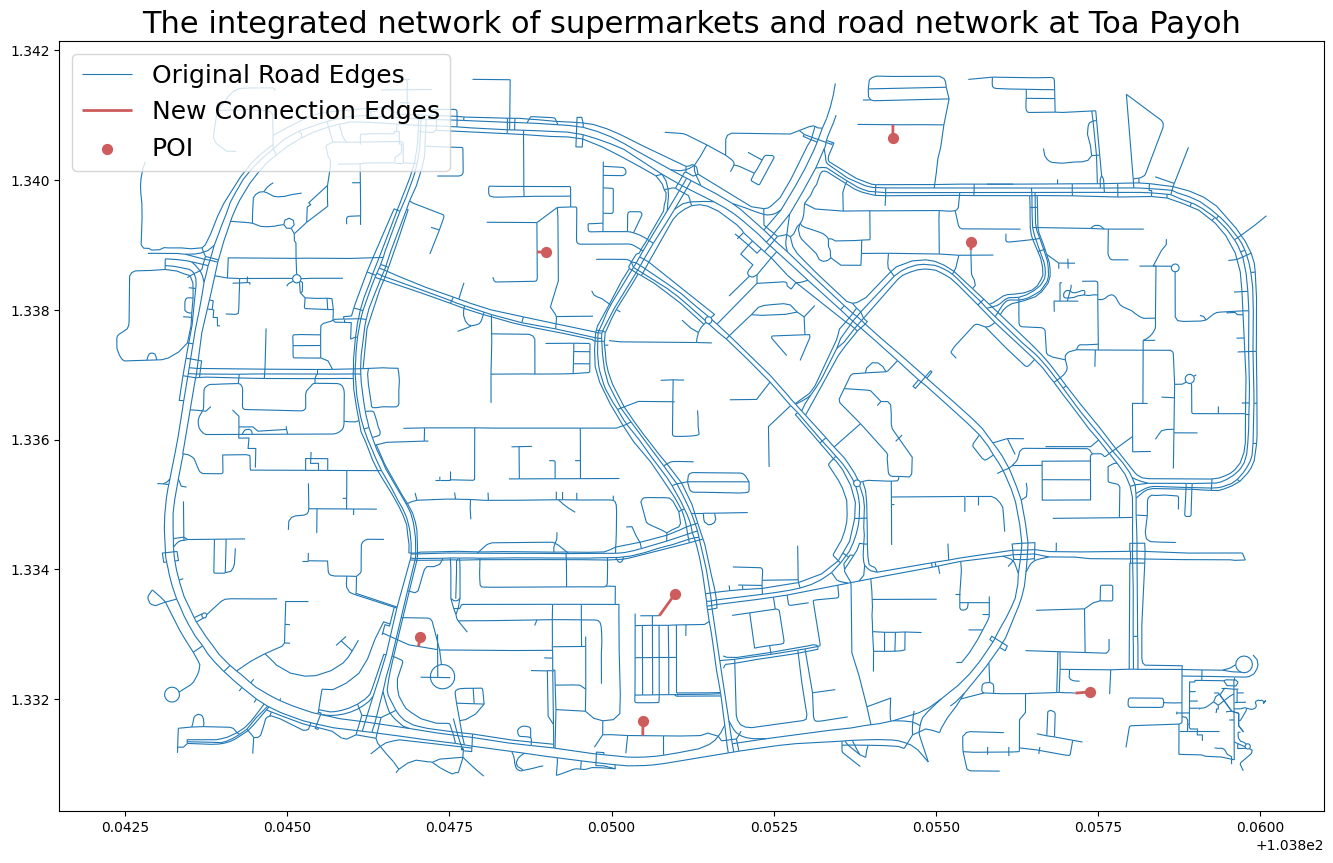

In [12]:
# output
poi_links = new_edges[new_edges['highway'] == 'projected_footway']
ax = edges.plot(linewidth=0.8, figsize=(18,10), label='Original Road Edges')
poi_links.plot(color='indianred', linewidth=2, ax=ax, label='New Connection Edges')
pois.plot(color='indianred', marker='.', markersize=200, ax=ax, label='POI')
ax.legend(loc=2, fontsize=18)
ax.set_title('The integrated network of supermarkets and road network at Toa Payoh', fontsize=22);